In [38]:
import numpy as np
import fenics as fen
import scipy.sparse

class TimeHarmonicMaxwellProblem(object):
    """
    Finite element solver for solutions to the time harmonic
    Maxwell's equations formulated in the vector potential A
    
        \/ x ((1 / mu) \/ x A) - eps * omega^2 * A = j

    with boundary conditions

        A = A_D                     (Dirichlet boundaries, B_D)
        ((1 / mu) \/ x A) x n = g_N   (Neumann boundaries, B_N)
 
    Members
    -------
    V : dolfin.functions.functionspace.FunctionSpace
        Real FE space.
    A : dolfin.functions.function.TrialFunction
        Trial function.
    v : dolfin.functions.function.TestFunction
        Test function.
    K : dolfin.cpp.la.Matrix
        Stiffness matrix.  
    M : dolfin.cpp.la.Matrix
        Mass matrix.
    L : dolfin.cpp.la.Vector
        Source term.
    L : dolfin.cpp.la.Vector
        Neumann boundary term.
    mu : dolfin.functions.expression.Expression
        Permeability.
    eps : dolfin.functions.expression.Expression
        Permittivity.
    j : dolfin.functions.expression.Expression
        Current density
    B_D : dolfin.cpp.mesh.SubDomain
        SubDomain object locating the Dirichlet boundary.
    B_N : dolfin.cpp.mesh.SubDomain
        SubDomain object locating the Neumann boundary.
    A_0 : dolfin.functions.expression.Expression
        Dirichlet boundary condition.
    g : dolfin.functions.expression.Expression
        Neumann boundary condition.
    A_sol : dolfin.functions.function.Function
        Solution to the variational problem.
    F_norm : dolfin.cpp.la.Matrix
        Matrix used to compute L2-norm of A_sol.
    bc : dolfin.fem.bcs.DirichletBC
        Dirichlet boundary condition object.
    omega : float
        Frequency for which the variational problem is solved.

    Methods
    -------
    setup() : None -> None
        Assemble the stiffness, mass, and source terms.
    solve(omega) : float -> None
        Computes the solution to the weak variational problem at omega.
     tosparse(A) : dolfin.cpp.la.Matrix -> scipy.sparse.csr_matrix
        Convert dolfin matrix to scipy sparse matrix in the CSR format.
    ...

    References
    ----------
    [1] FEniCS Project 2021: https://fenicsproject.org/
    [2] ...
    
    Usage
    -----
    Square waveguide with perfectly conducting walls and an inlet.

    >>> V = fen.FunctionSpace(fen.UnitSquareMesh(10, 10), 'P', 1)
    >>> mu = eps = fen.Constant(1.0)
    >>> j = fen.Constant(0.0)
    >>>
    >>> class B_D(fen.SubDomain):
    >>>     def inside(self, x, on_boundary):
    >>>         return not fen.near(x[0], 0.0)
    >>> class B_N(fen.SubDomain):
    >>>    def inside(self, x, on_boundary):
    >>>         return fen.near(x[0], 0.0)
    >>> 
    >>> A_D = fen.Constant(0.0)
    >>> g_N = fen.Constant(1.0)
    >>>
    >>> MP = MaxwellProblem(V, mu, eps, j, B_D(), B_N(), A_D, g_N)
    >>> MP.setup()
    >>> MP.solve(1)
    >>> A_sol = MP.get_solution()
    """

    def __init__(self, V, mu, eps, j, B_D, B_N, A_D, g_N):
        self.V = V
        self.A = fen.TrialFunction(self.V)
        self.v = fen.TestFunction(self.V)
        self.K = None
        self.M = None
        self.L = None
        self.N = None
        self.mu = mu
        self.eps = eps
        self.j = j
        self.B_D = B_D
        self.B_N = B_N
        self.A_D = A_D
        self.g_N = g_N
        self.A_sol = None
        self.F_norm = None
        self.bc = None
        self.omega = None

    def setup(self):
        # Boundary function to identify Dirichlet and Neumann boundaries
        mesh = self.V.mesh()
        boundary_type = fen.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
        boundary_type.set_all(0)
        self.B_D.mark(boundary_type, 1)
        self.B_N.mark(boundary_type, 2)

        # Dirichlet boundary conditions
        self.bc = fen.DirichletBC(self.V, self.A_D, boundary_type, 1)

        # Neumann boundary conditions
        ds = fen.Measure('ds', subdomain_data=boundary_type)
        self.N = fen.assemble(fen.dot(self.g_N, self.v) * ds(2))

        # Assembly of stiffness, mass, and forcing term
        self.K = fen.assemble(1/self.mu * fen.dot(fen.curl(self.A), fen.curl(self.v)) * fen.dx)
        self.bc.apply(self.K)

        self.M = fen.assemble(self.eps * fen.dot(self.A, self.v) * fen.dx)
        self.bc.zero(self.M)

        self.L = fen.assemble(fen.dot(self.j, self.v) * fen.dx)
        self.bc.apply(self.L)

    def solve(self, omega):
        self.omega = omega
        LHS = self.K - omega**2 * self.M
        RHS = self.L + self.N
        self.A_sol = fen.Function(self.V)
        fen.solve(LHS, self.A_sol.vector(), RHS)

    @staticmethod
    def tosparse(A):
        A_mat = fen.as_backend_type(A).mat()
        A_sparse = scipy.sparse.csr_matrix(A_mat.getValuesCSR()[::-1])
        return A_sparse

    def get_K(self): 
        return self.tosparse(self.K)
    
    def get_M(self): 
        return self.tosparse(self.M)
    
    def get_L(self): 
        return self.L.get_local()

    def get_N(self):
        return self.N.get_local()
    
    def get_solution(self):
        return self.A_sol

    def compute_solution_norm(self):
        if self.F_norm is None:
            self.F_norm = fen.assemble(fen.dot(fen.TrialFunction(self.V), fen.TestFunction(self.V)) * fen.dx)
        return pow((self.A_sol.vector()*(self.F_norm*self.A_sol.vector())).sum(), 0.5)
    
    def get_boundary_indices_and_values(self):
        boundary_dict = self.bc.get_boundary_values()
        boundary_indices = list(boundary_dict.keys())
        boundary_values = list(boundary_dict.values())
        return boundary_indices, boundary_values

    def get_valid_indices(self):
        boundary_indices, _ = self.get_boundary_indices_and_values()
        all_indices = self.V.dofmap().dofs()
        valid_indices = np.delete(all_indices, boundary_indices)
        return valid_indices
    
    def insert_boundary_values(self, A_vec):
        boundary_indices, boundary_values = self.get_boundary_indices_and_values()
        valid_indices = self.get_valid_indices()
        A_vec_inserted = np.empty(self.V.dim())
        A_vec_inserted[valid_indices] = A_vec
        A_vec_inserted[boundary_indices] = boundary_values
        return A_vec_inserted

In [39]:
import numpy as np
import fenics as fen
import mshr
import matplotlib.pyplot as plt

class RectangularWaveguide(TimeHarmonicMaxwellProblem):
    def __init__(self, Lx, Ly, Nx, Ny, g_N):
        self.Lx = Lx
        self.Ly = Ly
        mesh = fen.RectangleMesh(fen.Point(0.0, 0.0), fen.Point(self.Lx, self.Ly), Nx, Ny, 'crossed')
        V = fen.FunctionSpace(mesh, 'P', 1)

        mu = fen.Expression('1.0', degree=2)
        eps = fen.Expression('1.0', degree=2)
        j = fen.Expression('0.0', degree=2)

        class B_N(fen.SubDomain):
            def inside(self_, x, on_boundary):
                return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<self.Ly

        class B_D(fen.SubDomain):
            def inside(self, x, on_boundary):
                return on_boundary and not B_N().inside(x, 'on_boundary')

        A_D = fen.Expression('0.0', degree=2)

        MaxwellProblem.__init__(self, V, mu, eps, j, B_D(), B_N(), A_D, g_N)

    def plot_solution(self):
        plt.title(f'Solution to system at frequency \u03C9 = {self.omega} rad/s')
        fig = fen.plot(self.A_sol)
        plt.colorbar(fig, orientation='horizontal')

    def plot_external_solution(self, A_vec, contains_boundary_values=False, omega=None):
        plt.figure()
        if omega is not None:
            plt.title(f'Solution to system at frequency \u03C9 = {omega} rad/s')
        A_func = fen.Function(self.V)
        if not contains_boundary_values:
            A_vec = self.insert_boundary_values(A_vec)
        A_func.vector()[:] = A_vec
        fen.plot(A_func)
        fig = fen.plot(self.A_sol)
        plt.colorbar(fig, orientation='horizontal')
        plt.show()

    def plot_g_N(self):
        ax = plt.axes(projection='3d')
        all_coords = WG.V.tabulate_dof_coordinates()
        inlet_coords = np.array([x for x in all_coords if self.B_N.inside(x, 'on_boundary')])
        g_N_coords = [self.g_N(x) for x in inlet_coords]
        ax.plot3D(inlet_coords[:, 0], inlet_coords[:, 1], g_N_coords)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('g_N(x, y)')
        ax.set_ylim(0.0, self.Ly)
        ax.set_xlim(0.0, self.Lx)
        X = np.array([[0.0, self.Lx], [0.0, self.Lx]])
        Y = np.array([[0.0, 0.0], [self.Ly, self.Ly]])
        Z = np.array([[0.0, 0.0], [0.0, 0.0]])
        ax.plot_surface(X, Y, Z, color='k', alpha=0.2)
        plt.tight_layout()
        plt.show()

    def get_analytical_eigenfrequencies(self, a, b):
        freqs = lambda n, m: np.pi*pow(n**2/(self.Ly)**2 + (m+0.5)**2/(self.Lx)**2 , 0.5)
        n_max = np.ceil(b * self.Ly / np.pi).astype('int')
        m_max = np.ceil(b * self.Lx / np.pi - 0.5).astype('int')
        eigs = np.unique(np.frompyfunc(freqs, 2, 1).outer(range(1, n_max+1), range(m_max+1)))
        return [e for e in eigs if a <= e and e <= b]

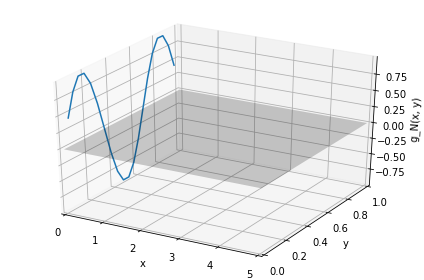

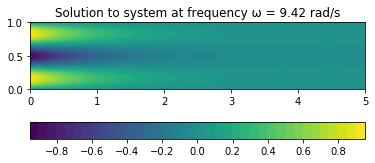

In [100]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 3
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
WG.plot_g_N()
plt.show()
WG = RectangularWaveguide(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
WG.setup()
WG.solve(3*3.14)
WG.plot_solution()

In [41]:
import scipy.sparse.linalg
import matplotlib.pyplot as plt

def solve_eigenproblem(K, M, a=-np.inf, b=np.inf, k=10, valid_indices=None, v0=None):

    if valid_indices is not None:
        K = K[valid_indices, :][:, valid_indices]
        M = M[valid_indices, :][:, valid_indices]
        if v0 is not None:
            v0 = v0[valid_indices]
    
    if a == -np.inf or b == np.inf:
        sigma = 0.0
    else:
        sigma = (a + b) / 2.0
        
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(K, k=k, M=M, sigma=sigma, v0=v0)
    eigvals = np.sqrt(eigvals)
    
    eigvals_in_ab = [e1 for e1 in eigvals if a <= e1 and e1 <= b]
    eigvecs_in_ab = [e2 for e1, e2 in zip(eigvals, eigvecs.T) if a <= e1 and e1 <= b]

    if len(eigvals_in_ab) == k:
        print(f'WARNING: Found exactly {k} eigenvalues within [{a}, {b}].')
        print('Increase parameter "k" to make sure all eigenvalues are found.')
    
    return eigvals_in_ab, eigvecs_in_ab

Increase parameter "k" to make sure all eigenvalues are found.


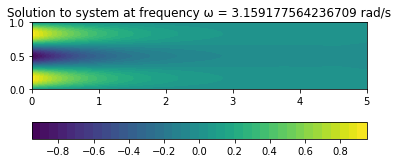

In [42]:
eigval, eigvec = solve_eigenproblem(WG.get_K(), WG.get_M(), k=1, valid_indices=WG.get_valid_indices())
WG.plot_external_solution(eigvec, omega=eigval[0])

In [43]:
def plot_L2_norms(ax, WG, omegas, **kwargs):
    L2_norms = np.empty(len(omegas))
    for i, omega in enumerate(omegas):
        WG.solve(omega)
        L2_norms[i] = WG.compute_solution_norm()
    ax.plot(omegas, L2_norms, **kwargs)
    ax.set_yscale('log')

In [44]:
def plot_analytical_eigenfrequencies(ax, WG, a, b, **kwargs):
    eigfreqs = WG.get_analytical_eigenfrequencies(a, b)
    ax.vlines(eigfreqs, ymin=0, ymax=1, **kwargs)

In [45]:
def plot_numerical_eigenfrequencies(ax, WG, a, b, **kwargs):
    K = WG.get_K()
    M = WG.get_M()
    valid_indices = WG.get_valid_indices()
    eigfreqs, _ = solve_eigenproblem(WG.get_K(), WG.get_M(), a=a, b=b, k=50, valid_indices=WG.get_valid_indices(), v0=WG.get_N())
    ax.vlines(eigfreqs, ymin=0, ymax=1, **kwargs)

In [46]:
def vec_dot_N(A_vec, WG):
    A_vec_inserted = WG.insert_boundary_values(A_vec)
    return np.inner(A_vec_inserted, WG.get_N())

def plot_eigvecs_dot_N(ax, WG, a, b, **kwargs):
    eigvals, eigvecs = solve_eigenproblem(WG.get_K(), WG.get_M(), a=a, b=b, k=50, valid_indices=WG.get_valid_indices(), v0=WG.get_N())
    dotproducts = [vec_dot_N(vec, WG) for vec in eigvecs]    
    ax.bar(eigvals, np.abs(dotproducts), **kwargs)
    ax.set_yscale('log')

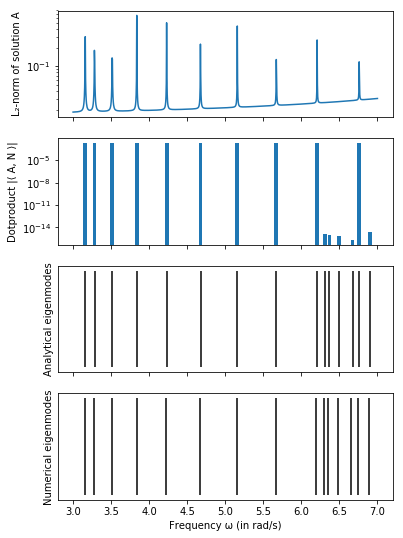

In [47]:
fig, ax = plt.subplots(4, 1, figsize=(6, 9), sharex=True)
omegas = np.linspace(3, 7, 1000)
plot_L2_norms(ax[0], WG, omegas)
plot_eigvecs_dot_N(ax[1], WG, omegas[0], omegas[-1], width=0.05)
plot_numerical_eigenfrequencies(ax[2], WG, omegas[0], omegas[-1])
plot_analytical_eigenfrequencies(ax[3], WG, omegas[0], omegas[-1])
ax[0].set_ylabel('L\u2082-norm of solution A')
ax[1].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[2].set_ylabel('Analytical eigenmodes')
ax[2].set_yticks([])
ax[3].set_ylabel('Numerical eigenmodes')
ax[3].set_yticks([])
ax[3].set_xlabel('Frequency \u03C9 (in rad/s)')
plt.show()

In [48]:
omega = 3.15
WG_timing = RectangularWaveguide(Lx=5.0, Ly=1.0, Nx=51, Ny=11, g_N=fen.Expression('1.', degree=2))
WG_timing.setup()

In [49]:
LHS = WG_timing.K - omega**2 * WG_timing.M
RHS = WG_timing.L + WG_timing.N
A_sol = fen.Function(WG_timing.V)
%timeit fen.solve(LHS, A_sol.vector(), RHS)

4.23 ms ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
k = 1
valid_indices = WG_timing.get_valid_indices()
K = WG_timing.get_K()[valid_indices, :][:, valid_indices]
M = WG_timing.get_M()[valid_indices, :][:, valid_indices]
%timeit scipy.sparse.linalg.eigsh(K, k=k, M=M)

76.9 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
import numpy as np
import fenics as fen
import mshr
import matplotlib.pyplot as plt

class CuboidWaveguide(TimeHarmonicMaxwellProblem):
    def __init__(self, Lx, Ly, Lz, Nx, Ny, Nz, g_N):
        self.Lx, self.Ly, self.Lz = Lx, Ly, Lz
        mesh = fen.BoxMesh(fen.Point(0.0, 0.0, 0.0), fen.Point(self.Lx, self.Ly, self.Lz), Nx, Ny, Nz)
        V = fen.FunctionSpace(mesh, 'N1curl', 1)

        mu = fen.Expression('1.0', degree=2)
        eps = fen.Expression('1.0', degree=2)
        j = fen.Expression(('0.0', '0.0', '0.0'), degree=2)

        class B_N(fen.SubDomain):
            def inside(self_, x, on_boundary):
                return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<self.Ly and x[2]>0.0 and x[2]<self.Lz

        class B_D(fen.SubDomain):
            def inside(self, x, on_boundary):
                return on_boundary and not B_N().inside(x, 'on_boundary')

        A_D = fen.Expression(('0.0', '0.0', '0.0'), degree=2)

        MaxwellProblem.__init__(self, V, mu, eps, j, B_D(), B_N(), A_D, g_N)

    def plot_solution(self):
        plt.title(f'Solution to system at frequency \u03C9 = {self.omega} rad/s')
        fig = fen.plot(self.A_sol)

    def plot_external_solution(self, A_vec, contains_boundary_values=False, omega=None):
        raise NotImplementedError()

    def plot_g_N(self):
        raise NotImplementedError()

    def get_analytical_eigenfrequencies(self, a, b):
        freqs = lambda n, l, m: np.pi*pow(n**2/(self.Ly)**2 + l**2/(self.Lz)**2 + (m+0.5)**2/(self.Lx)**2 , 0.5)
        n_max = np.ceil(b * self.Ly / np.pi).astype('int')
        l_max = np.ceil(b * self.Ly / np.pi).astype('int')
        m_max = np.ceil(b * self.Lx / np.pi - 0.5).astype('int')
        eigs_nlm = np.empty((n_max, m_max+1, l_max+1))
        for n in range(1, n_max+1):
            for l in range(1, l_max+1):
                for m in range(m_max+1):
                    eigs_nlm[n-1, l-1, m] = freqs(n, m, l)
        eigs = np.unique(eigs_nml)
        return [x for x in eigs if a <= x and x <= b]

In [63]:
Lx, Ly, Lz = 5.0, 1.0, 1.0
Nx, Ny, Nz = 51, 11, 11
m = 1
#g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
g_N = fen.Expression(('1.0', '0.0', '0.0'), degree=2, Ly=Ly, m=m)
CW = CuboidWaveguide(Lx=Lx, Ly=Ly, Lz=Lz, Nx=Nx, Ny=Ny, Nz=Nz, g_N=g_N)
CW.setup()
CW.solve(3*3.14)
#CW.plot_solution()

KeyboardInterrupt: 

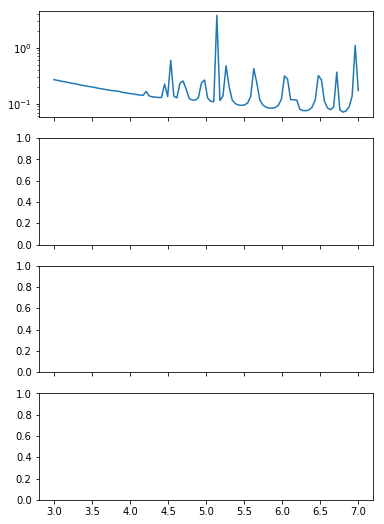

In [65]:
fig, ax = plt.subplots(4, 1, figsize=(6, 9), sharex=True)
omegas = np.linspace(3, 7, 100)
plot_L2_norms(ax[0], CW, omegas)
plot_eigvecs_dot_N(ax[1], CW, omegas[0], omegas[-1], width=0.05)
plot_numerical_eigenfrequencies(ax[2], CW, omegas[0], omegas[-1])
plot_analytical_eigenfrequencies(ax[3], CW, omegas[0], omegas[-1])
ax[0].set_ylabel('L\u2082-norm of solution A')
ax[1].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[2].set_ylabel('Analytical eigenmodes')
ax[2].set_yticks([])
ax[3].set_ylabel('Numerical eigenmodes')
ax[3].set_yticks([])
ax[3].set_xlabel('Frequency \u03C9 (in rad/s)')
plt.show()

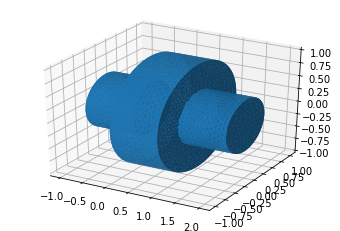

In [87]:
mesh = fen.Mesh('cylinder.xml')
fen.plot(mesh)

In [97]:
def store_solutions_in_matrix(omegas, WG):
    U = np.empty((WG.V.dim(), len(omegas)))
    for i, omega in enumerate(omegas):
        WG.solve(omega)
        U[:, i] = WG.get_solution().vector().get_local()
    G = U.T @ WG.get_M().todense() @ U
    return G

In [98]:
G = store_solutions_in_matrix(np.linspace(3, 5, 10), WG)
R = np.linalg.cholesky(G)